# Regression example: predict housing prices

> This chapter is inspired by the book [Hands-On Machine Learning](https://github.com/ageron/handson-ml2) written by Aurélien Géron.

## Learning objectives

- Discover how to train a Machine Learning model on tabular data.
- Get familiar with the general workflow of a supervised ML project.
- Learn how to leverage the [pandas](https://pandas.pydata.org/) and [scikit-learn](https://scikit-learn.org) libraries.

> You may test the trained model [here](https://housing-prices-api.herokuapp.com/).

## Environment setup

In [1]:
import platform

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# For saving models and pipelines to disk
import joblib

In [2]:
# Setup plots

# Include matplotlib graphs into the notebook, next to the code
# https://stackoverflow.com/a/43028034/2380880
%matplotlib inline

# Improve plot quality
%config InlineBackend.figure_format = "retina"

# Setup seaborn default theme
# http://seaborn.pydata.org/generated/seaborn.set_theme.html#seaborn.set_theme
sns.set_theme()

In [3]:
# Print environment info
print(f"Python version: {platform.python_version()}")
print(f"NumPy version: {np.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")

Python version: 3.11.1
NumPy version: 1.26.3
scikit-learn version: 1.3.2


## The Machine Learning project workflow

### Main steps of a supervised learning project

1. **Frame** the problem.
1. Collect, analyze and prepare **data**.
1. Select and train several **models** on data.
1. **Tune** the most promising model.
1. **Deploy** the model to production and monitor it.

[![ML workflow by RedHat](_images/wiidii_ml_workflow.png)](https://www.redhat.com/files/summit/session-assets/2019/T957A0.pdf)


## Step 1: frame the problem

### Key questions

- What is the business objective?
- How good are the current solutions?
- What data is available?
- Is the problem a good fit for ML?
- What is the expected learning type (supervised or not, batch/online...)?
- How will the model's performance be evaluated?

### Properties of ML-friendly problems

- Difficulty to express the actions as rules.
- Data too complex for traditional analytical methods.
  - High number of features.
  - Highly correlated data (data with similar or closely related values).
- Performance > interpretability.
- Data quality is paramount.

### Business objective: predict housing prices

- Inputs: housing properties in an area.
- Output: median housing price in the area.

[![Kaggle houses banner](_images/kaggle_housesbanner.png)](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)

## Step 2: collect, analyze and prepare data

### A crucial step

- Real data is messy, incomplete and often scattered across many sources.

- Data labeling is a manual and tedious process.

- Predefined datasets offer a convenient way to bypass the data wrangling step. Alas, using one is not always an option.

### The California housing dataset

- Based on data from the 1990 California census.
- Slightly modified for teaching purposes by Aurélien Géron ([original version](https://www.dcc.fc.up.pt/%7Eltorgo/Regression/cal_housing.html)).
- Raw CSV file is available [here](https://raw.githubusercontent.com/bpesquet/ainotes/master/data/california_housing.csv).

### Step 2.1: discover data

Our first objective is to familiarize ourselves with the dataset.

Once data is loaded, the [pandas](https://pandas.pydata.org/) library  provides many useful functions for making sense of it.

In [4]:
# Load the dataset in a pandas DataFrame
# The df_ prefix is used to distinguish dataframes from plain NumPy arrays
dataset_url = "https://raw.githubusercontent.com/bpesquet/ainotes/master/data/california_housing.csv"
df_housing = pd.read_csv(dataset_url)

# Print dataset shape (rows and columns)
print(f"Dataset shape: {df_housing.shape}")

Dataset shape: (20640, 10)


In [5]:
# Print a concise summary of the dataset
# 9 attributes are numerical, one ("ocean_proximity") is categorical
# "median_house_value" is the target attribute
# One attribute ("total_bedrooms") has missing values
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# Show 10 random samples of the dataset
df_housing.sample(n=10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
19275,-122.79,38.42,9.0,4967.0,885.0,2581.0,915.0,5.0380,185600.0,<1H OCEAN
3980,-118.61,34.19,34.0,703.0,127.0,369.0,127.0,4.3125,210100.0,<1H OCEAN
12186,-117.34,33.71,10.0,2591.0,486.0,1255.0,425.0,3.1513,154300.0,<1H OCEAN
7335,-118.18,33.98,38.0,1477.0,374.0,1514.0,408.0,2.5703,178600.0,<1H OCEAN
19953,-119.33,36.22,29.0,1735.0,323.0,805.0,293.0,3.5039,89900.0,INLAND
20141,-119.06,34.36,52.0,1409.0,359.0,981.0,304.0,2.7951,199300.0,<1H OCEAN
525,-122.24,37.77,52.0,1711.0,386.0,885.0,373.0,3.6417,206300.0,NEAR BAY
9816,-121.93,36.62,39.0,869.0,173.0,406.0,165.0,4.0313,253800.0,NEAR OCEAN
10945,-117.88,33.74,19.0,2261.0,642.0,3545.0,635.0,2.5224,148500.0,<1H OCEAN
6334,-117.96,33.99,25.0,1348.0,210.0,660.0,200.0,5.2852,297600.0,<1H OCEAN


In [7]:
# Print descriptive statistics for all numerical attributes
df_housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Step 2.2: analyze data

The objective here is to gain insights about the data, in order to prepare it optimally for training.

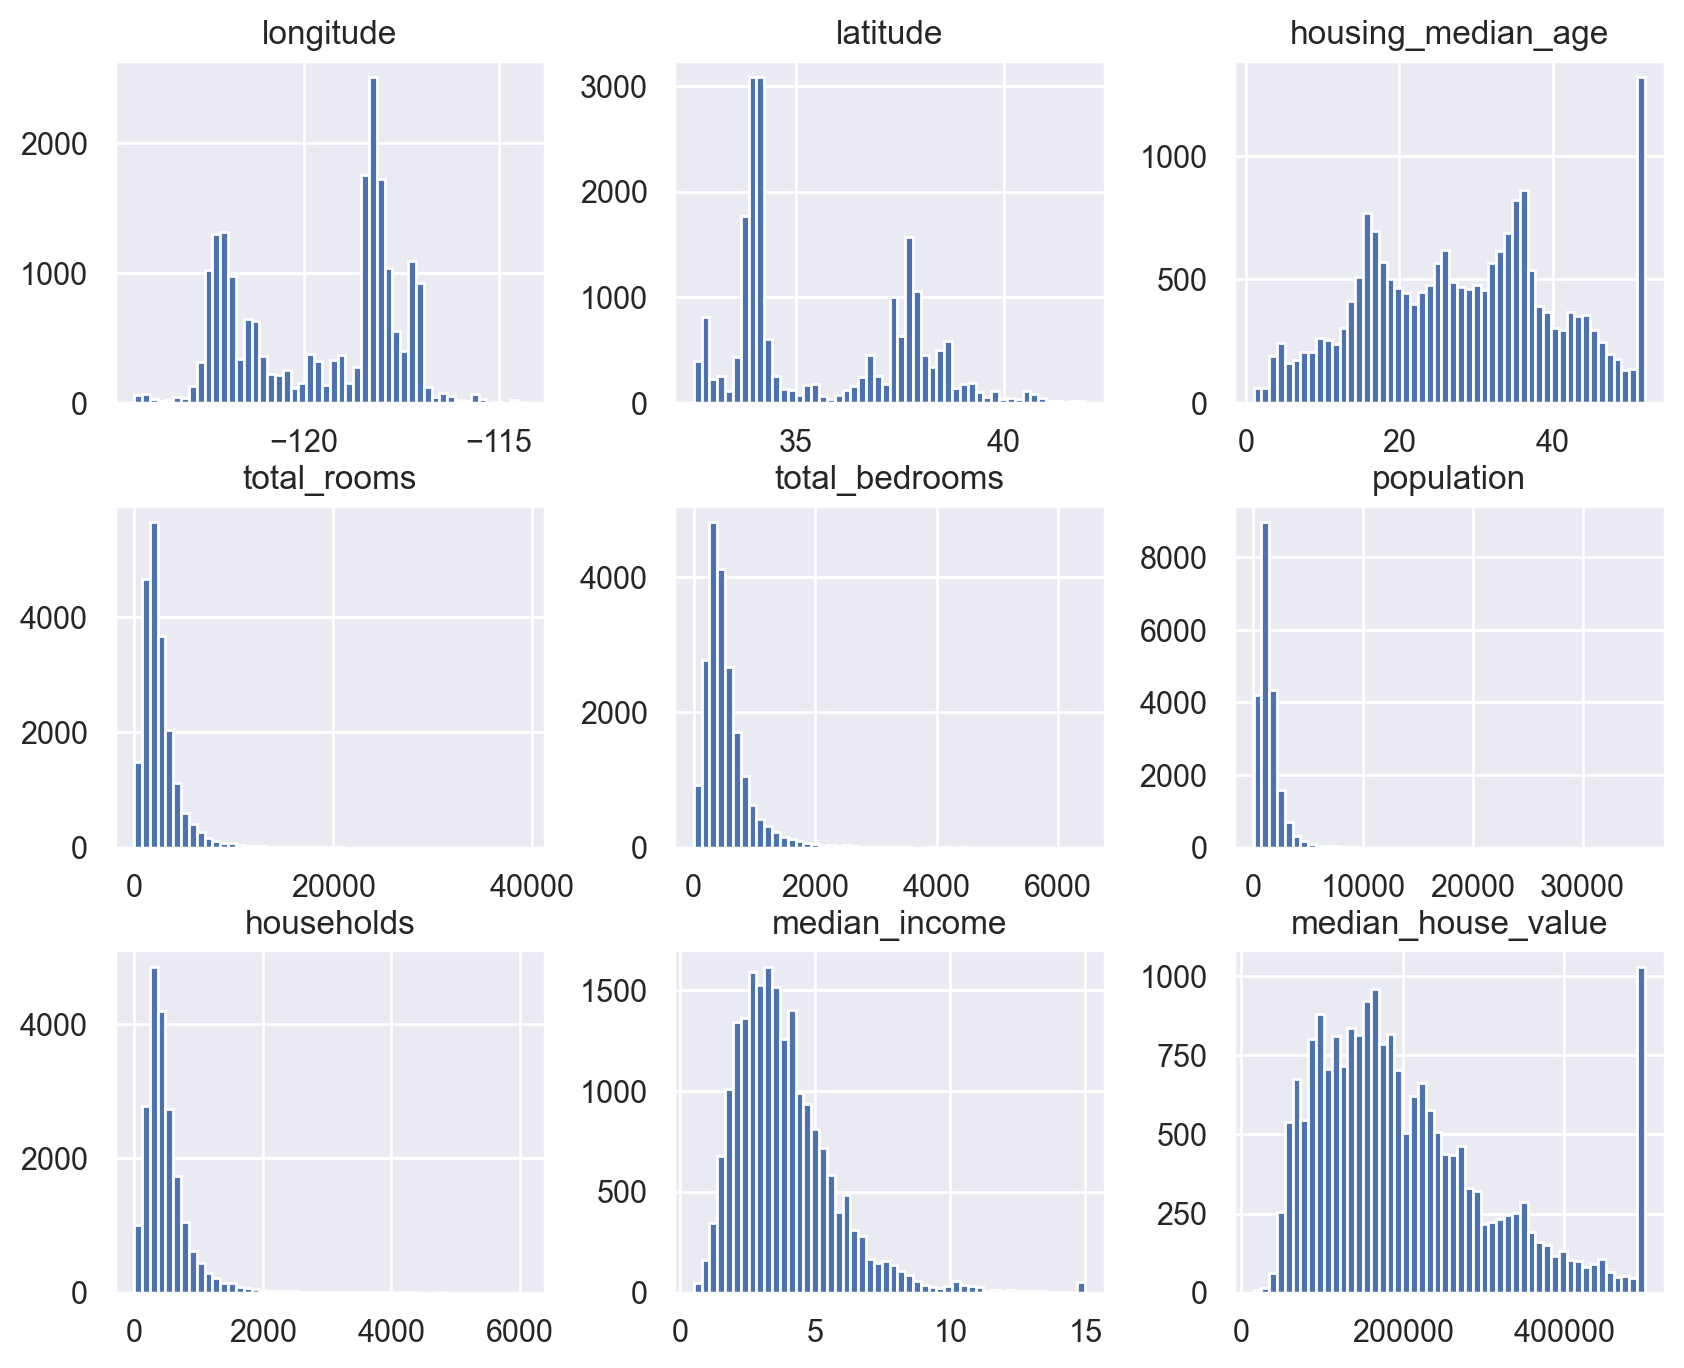

In [8]:
# Plot histograms for all numerical attributes
df_housing.hist(bins=50, figsize=(10, 8))
plt.show()

In [9]:
def plot_geo_data(df):
    """Plot a geographical representation of the data"""

    # This dataset has the particularity of including geographical coordinates
    # Visualise prices relative to them
    df.plot(
        kind="scatter",
        x="longitude",
        y="latitude",
        alpha=0.4,
        s=df_housing["population"] / 100,
        label="population",
        figsize=(11, 8),
        c="median_house_value",
        cmap=plt.get_cmap("jet"),
        colorbar=True,
        sharex=False,
    )
    plt.legend()
    plt.show()

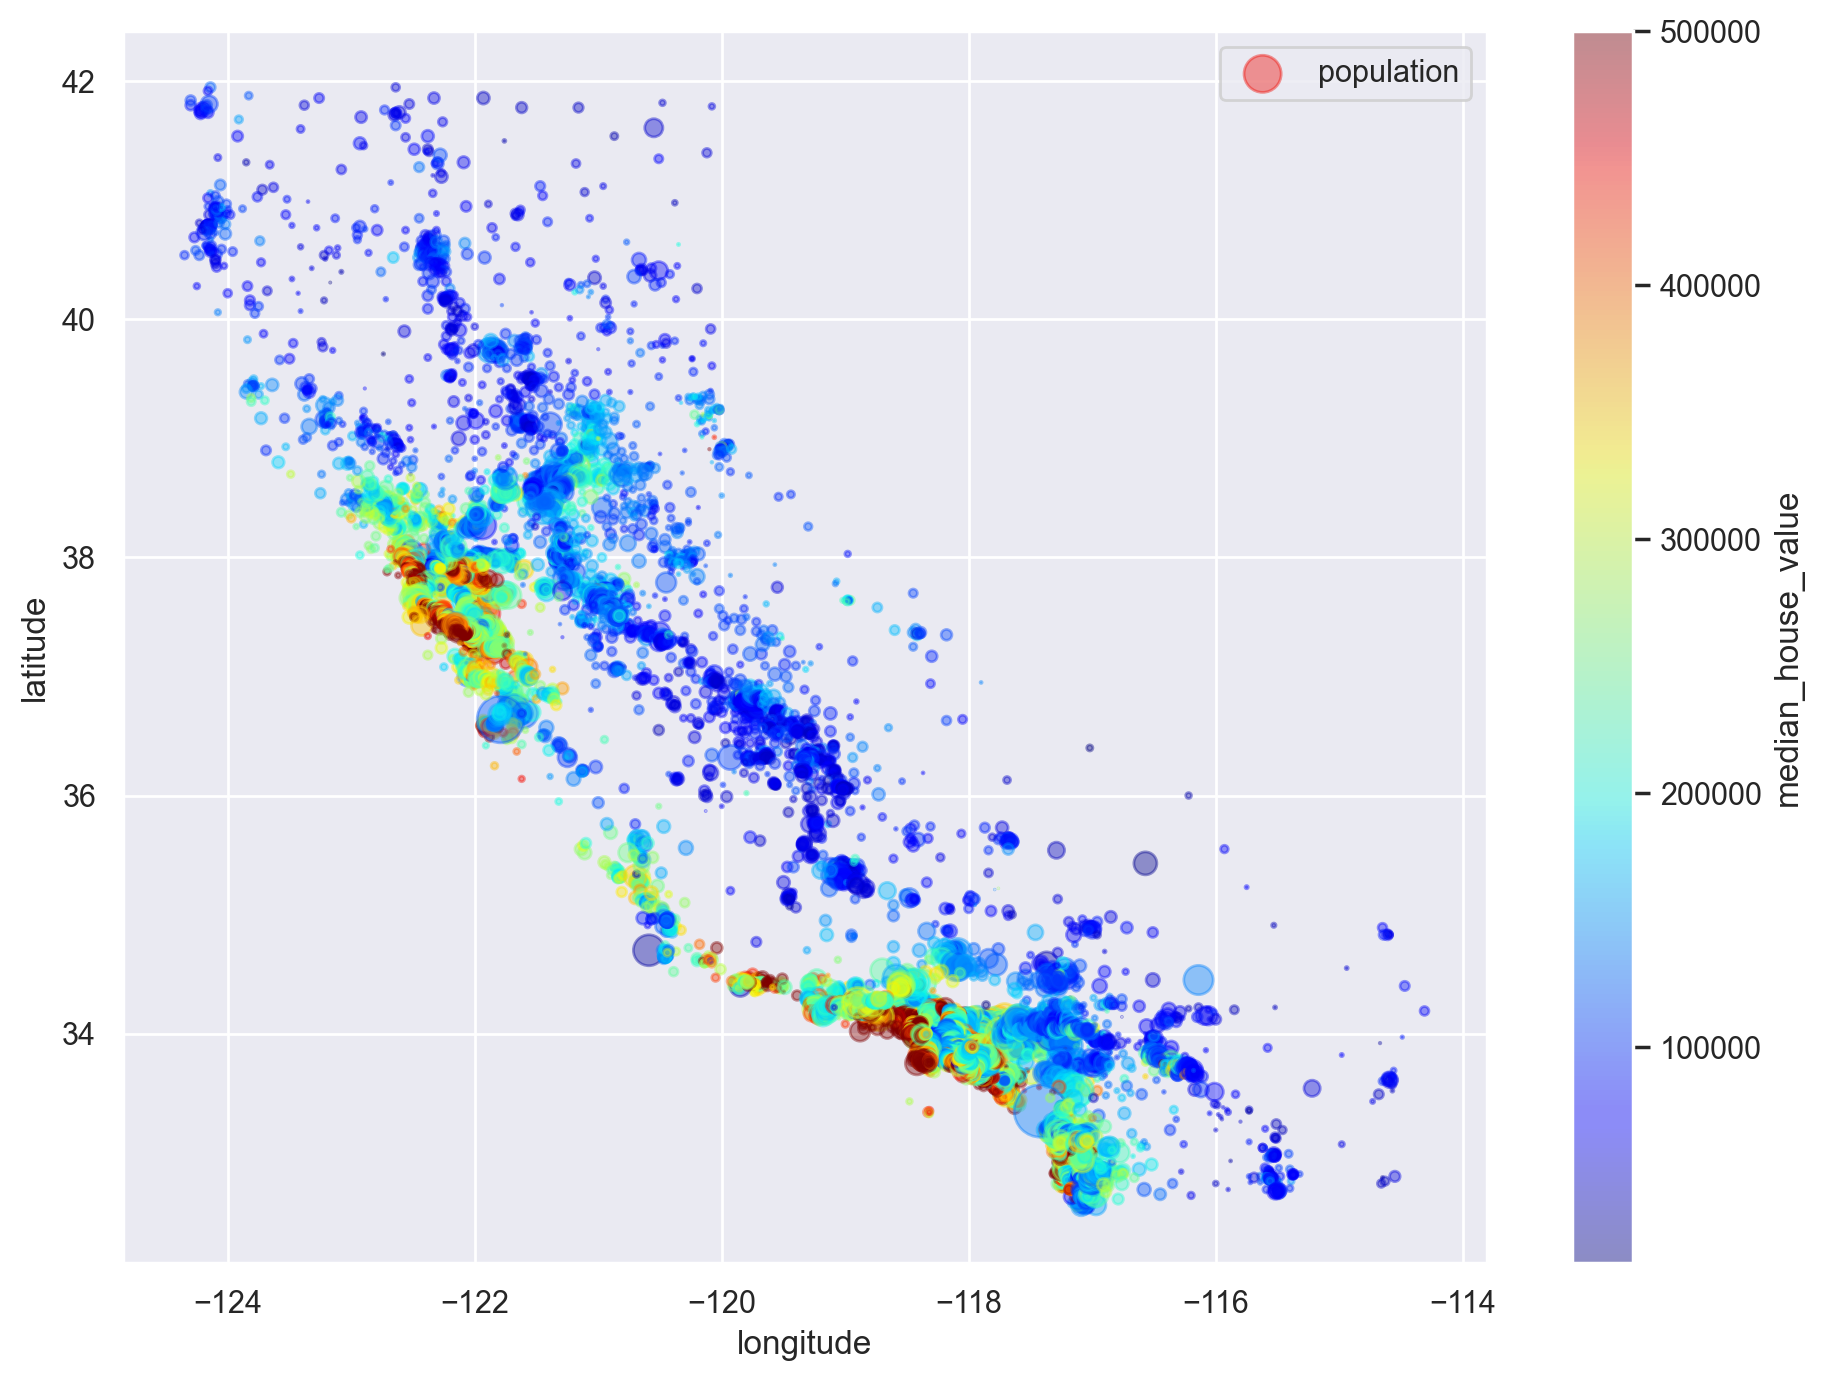

In [10]:
plot_geo_data(df_housing)

In [11]:
# Compute pairwise correlations of attributes
corr_matrix = df_housing.corr(numeric_only=True)

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [12]:
def plot_correlation_matrix(df):
    """Plot a correlation matrix for a DataFrame"""

    # Select numerical columns
    df_numerical = df.select_dtypes(include=[np.number])

    plt.subplots()
    sns.heatmap(
        df.corr(numeric_only=True),
        vmax=0.8,
        linewidths=0.01,
        square=True,
        annot=True,
        linecolor="white",
        xticklabels=df_numerical.columns,
        annot_kws={"size": 10},
        yticklabels=df_numerical.columns,
    )

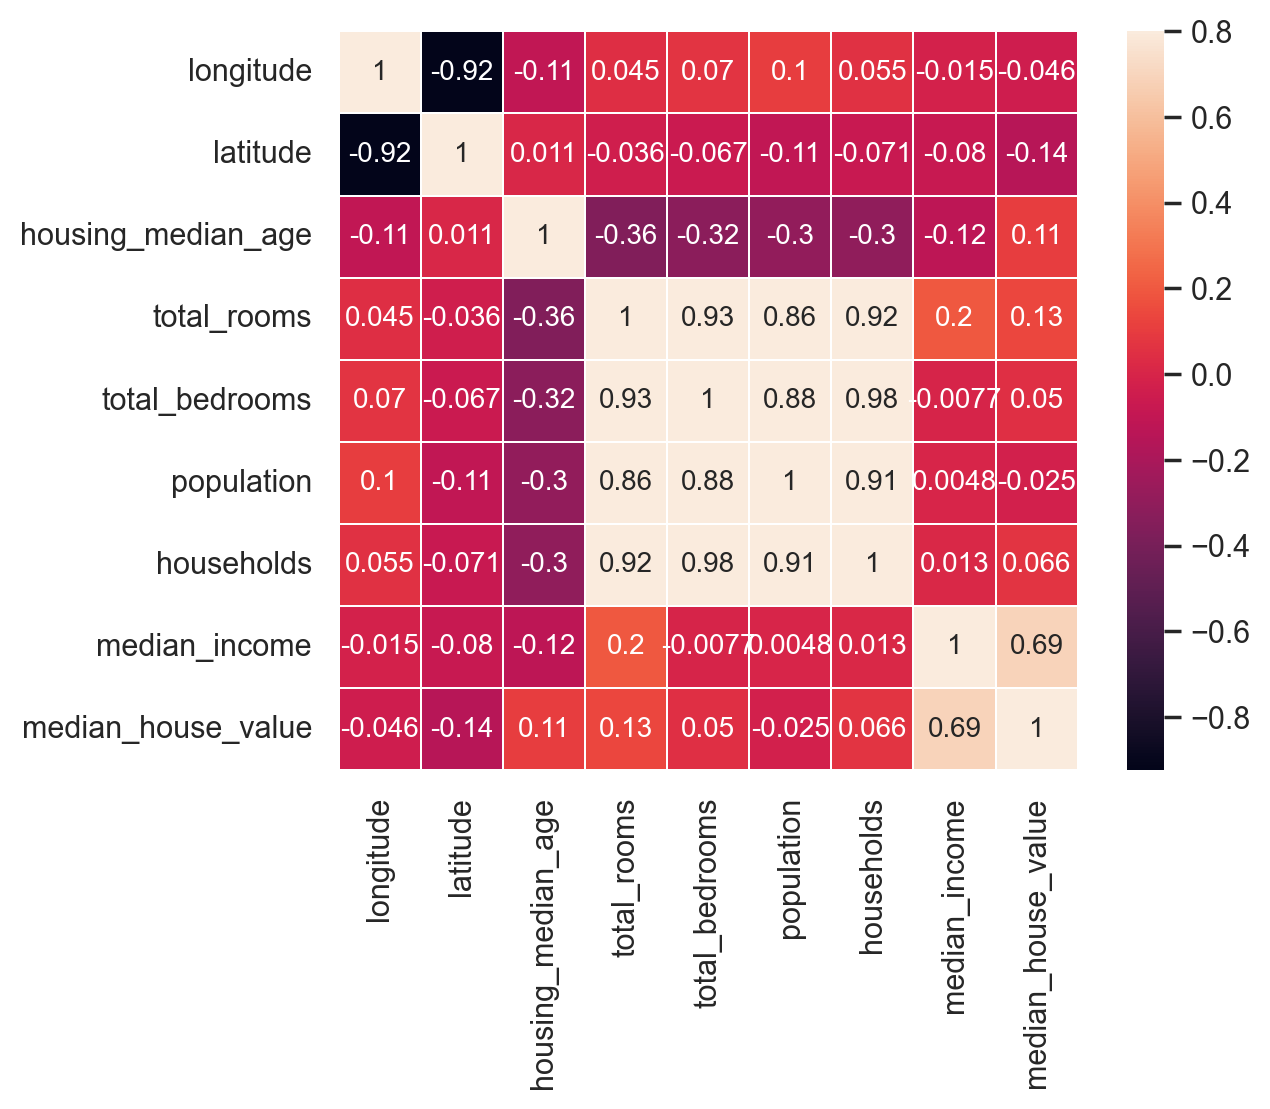

In [13]:
plot_correlation_matrix(df_housing)

### Step 2.3: split the dataset

A simple solution for splitting datasets is to use the `train_test_split`function from scikit-learn.

Just before or after that, inputs (features given to the model) have to be separated from targets (values it must predict).

[![Using train_test_split](_images/train-test-split.jpg)](https://mgalarnyk.github.io/)

In [14]:
# Separate inputs from targets

# Target attribute is removed to create inputs
df_x = df_housing.drop("median_house_value", axis="columns")

# Targets are stored separately in a new variable
df_y = df_housing["median_house_value"]

print(f"df_x: {df_x.shape}. df_y: {df_y.shape}")

df_x: (20640, 9). df_y: (20640,)


In [15]:
# Split dataset between training and test sets
# A unique call to train_test_split is mandatory to maintain inputs/target correspondance between samples
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
    df_x, df_y, test_size=0.2
)

print(f"df_x_train: {df_x_train.shape}. df_y_train: {df_y_train.shape}")
print(f"df_x_test: {df_x_test.shape}. df_y_test: {df_y_test.shape}")

df_x_train: (16512, 9). df_y_train: (16512,)
df_x_test: (4128, 9). df_y_test: (4128,)


### Step 2.4: data preprocessing

For this dataset, this task involves:

- Handling missing values.
- Scaling data.
- Transforming categorical values into numeric form.

In [16]:
# Compute percent of missing values among features
print(df_x_train.isnull().sum() * 100 / df_x_train.isnull().count())

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        0.987161
population            0.000000
households            0.000000
median_income         0.000000
ocean_proximity       0.000000
dtype: float64


In [17]:
# Show random samples with missing values
df_x_train[df_x_train.isnull().any(axis=1)].sample(n=5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
5236,-118.23,33.94,36.0,1110.0,NaN,1417.0,302.0,2.3333,<1H OCEAN
4391,-118.27,34.07,27.0,1190.0,NaN,1795.0,422.0,1.7016,<1H OCEAN
3529,-118.53,34.26,18.0,3674.0,NaN,1590.0,550.0,8.1760,<1H OCEAN
6052,-117.76,34.04,34.0,1914.0,NaN,1564.0,328.0,2.8347,INLAND
10428,-117.64,33.45,26.0,1528.0,NaN,607.0,218.0,6.2871,NEAR OCEAN


In [18]:
# Get numerical features
num_features = df_x_train.select_dtypes(include=[np.number]).columns
print(num_features)

# Get categorical features
cat_features = df_x_train.select_dtypes(include=[object]).columns
print(cat_features)

# Print all values for the "ocean_proximity" feature
df_x_train["ocean_proximity"].value_counts()

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')
Index(['ocean_proximity'], dtype='object')


ocean_proximity
<1H OCEAN     7308
INLAND        5248
NEAR OCEAN    2118
NEAR BAY      1833
ISLAND           5
Name: count, dtype: int64

### Preprocessing pipelines

Data preprocessing is done through a series of sequential operations on data (handling missing values, standardization, one-hot encoding...).

scikit-learn support the definition of **pipelines** for streamlining these operations. This is useful to prevent mistakes and oversights when preprocessing new data.

In [19]:
# This pipeline handles missing values and standardizes features
num_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("std_scaler", StandardScaler()),
    ]
)

# This pipeline applies the previous one on numerical features
# It also one-hot encodes the categorical features
full_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, num_features),
        ("cat", OneHotEncoder(), cat_features),
    ]
)

In [20]:
# Apply all preprocessing operations to the training set through pipelines
x_train = full_pipeline.fit_transform(df_x_train)

# Transform the targets DataFrame into a plain tensor
y_train = df_y_train.to_numpy()

# Print preprocessed data shape and first sample
# "ocean_proximity" attribute has 5 different values
# To represent them, one-hot encoding has added 4 features to the dataset
print(f"x_train: {x_train.shape}")
print(x_train[0])

# Data is now ready for model training :)

x_train: (16512, 13)
[-0.89481741  1.4186761   0.42423902 -0.71514653 -0.84035355 -0.66935592
 -0.81320157 -0.30118203  0.          1.          0.          0.
  0.        ]


## Step 3: select and train models

### An iterative and empirical step

At long last, our data is ready and we can start training models.

This step is often iterative and can be quite empirical. Depending on data and model complexity, it can also be resource-intensive.

![Busy training](_images/busy_training.jpg)

### The optimization/generalization dilemna

![Underfitting and overfitting](_images/underfitting_overfitting.png)

### Underfitting and overfitting

- **Underfitting** (sometimes called *bias*): insufficient performance on training set.
- **Overfitting** (sometimes called *variance*): performance gap between training and validation sets.

Ultimately, we look for a tradeoff between underfitting and overfitting.

The goal of the training step is to find a model powerful enough to **overfit the training set**.

### Step 3.1: choose an evaluation metric

Model performance is assessed through an **evaluation metric**. Like the loss function, it depends on the problem type.

A classic choice for regression tasks is the **Root Mean Square Error (RMSE)**. It gives an idea of how much error the trained model typically makes in its predictions. Of course, the smaller the better in that case.

$$\mathrm{RMSE}(\pmb{Y}, \pmb{Y'}) = \sqrt{\frac{1}{m}\sum_{i=1}^m (\pmb{y'}^{(i)} - \pmb{y}^{(i)})^2}$$

**Mean Absolute Error** (less sensitive to outliers) and **MSE** may also be used.

### Step 3.2: start with a baseline model

For each learning type (supervised, unsupervised...), several models of various complexity exist.

It is often useful to begin the training step by using a basic model. Its results will serve as a **baseline** when training more complicated models. In some cases, its performance might even be surprisingly good.

In [21]:
# Fit a linear regression model to the training set
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)


def compute_error(model, x, y_true):
    """Compute error (as root of MSE) for a model and a training set"""

    # Compute model predictions (median house prices) for training set
    y_pred = model.predict(x)

    # Compute the error between actual and expected median house prices
    error = np.sqrt(mean_squared_error(y_true, y_pred))
    return error


lin_error = compute_error(lin_model, x_train, y_train)
print(f"Training error for linear regression: {lin_error:.02f}")

Training error for linear regression: 68787.82


### Step 3.3: try other models

In [22]:
# Fit a decision tree model to the training set
dt_model = DecisionTreeRegressor()
dt_model.fit(x_train, y_train)

dt_error = compute_error(dt_model, x_train, y_train)
print(f"Training error for decision tree: {dt_error:.02f}")

Training error for decision tree: 0.00


### Step 3.4: Use a validation set to evaluate model performance

The previous result (*error = 0*) looks too good to be true. It might very well be a case of severe overfitting to the training set, which means the model won't perform well with unseen data.

One way to assert overfitting is to split training data between a smaller training set and a **validation set**, used only to evaluate model performance.

#### Cross-validation

A more sophisticated strategy is to apply **K-fold cross validation**. Training data is randomly split into $K$ subsets called *folds*. The model is trained and evaluated $K$ times, using a different fold for validation.

![K-fold Cross Validation](_images/k-fold-cross-validation.png)

In [23]:
def compute_crossval_mean_score(model, x, y_true):
    """Return the mean of cross validation scores for a model and a training set"""

    cv_scores = -cross_val_score(
        model, x, y_true, scoring="neg_mean_squared_error", cv=10
    )
    return np.sqrt(cv_scores).mean()


lin_cv_mean = compute_crossval_mean_score(lin_model, x_train, y_train)
print(f"Mean cross-validation error for linear regression: {lin_cv_mean:.02f}")

dt_cv_mean = compute_crossval_mean_score(dt_model, x_train, y_train)
print(f"Mean cross-validation error for decision tree: {dt_cv_mean:.02f}")

Mean cross-validation error for linear regression: 68923.83
Mean cross-validation error for decision tree: 67886.43


In [24]:
# Fit a random forest model to the training set
rf_model = RandomForestRegressor(n_estimators=20)
rf_model.fit(x_train, y_train)

rf_error = compute_error(rf_model, x_train, y_train)
print(f"Training error for random forest: {rf_error:.02f}")

rf_cv_mean = compute_crossval_mean_score(rf_model, x_train, y_train)
print(f"Mean cross-validation error for random forest: {rf_cv_mean:.02f}")

Training error for random forest: 19890.36
Mean cross-validation error for random forest: 49808.02


## Step 4: tune the most promising model

### Step 4.1: search for the best hyperparameters

Once a model looks promising, it must be **tuned** in order to offer the best compromise between optimization and generalization.

The goal is to find the set of model properties that gives the best performance. Model properties are often called **hyperparameters** (example: maximum depth for a decision tree).

This step can be either:

* manual, tweaking model hyperparameters by hand.
* automated, using a tool to explore the model hyperparameter spaces.

In [25]:
# Grid search explores a user-defined set of hyperparameter values
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {"n_estimators": [50, 100, 150], "max_features": [6, 8, 10, 12]},
]

# train across 5 folds, that's a total of 12*5=60 rounds of training
grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True,
)
grid_search.fit(x_train, y_train)

# Store the best model found
final_model = grid_search.best_estimator_

# Print the best combination of hyperparameters found
print(grid_search.best_params_)

{'max_features': 8, 'n_estimators': 150}


### Step 4.2: check final model performance on test dataset

Now is the time to evaluate the final model on the test set that we put apart before.

An important point is that preprocessing operations should be applied to test data using preprocessing values (mean, categories...) previously computed on training data. This prevents **information leakage** from test data ([explanation](https://machinelearningmastery.com/data-leakage-machine-learning/))

In [26]:
# Apply preprocessing operations to test inputs
# Calling transform() and not fit_transform() uses preprocessing values computed on training set
x_test = full_pipeline.transform(df_x_test)

# Transform the targets DataFrame into a plain tensor
y_test = df_y_test.to_numpy()

test_error = compute_error(final_model, x_test, y_test)
print(f"Test error for final model: {test_error:.02f}")

Test error for final model: 48497.64


### Using the model to make predictions on new data

In [27]:
# Create a new data sample
new_sample = [[-122, 38, 49, 3700, 575, 1200, 543, 5.2, "NEAR BAY"]]

# Put it into a DataFrame so that it can be preprocessed
df_new_sample = pd.DataFrame(new_sample)
df_new_sample.columns = df_x_train.columns
df_new_sample.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122,38,49,3700,575,1200,543,5.2,NEAR BAY


In [28]:
# Apply preprocessing operations to new sample
# Calling transform() and not fit_transform() uses preprocessing values computed on training set
x_new = full_pipeline.transform(df_new_sample)

# Use trained model to predict median housing price
y_new = final_model.predict(x_new)
print(f"Predicted median price: {y_new[0]:.02f}")

Predicted median price: 276357.40


## Step 5: deploy to production and maintain the system

### Step 5.1: save the final model and data pipeline

A trained model can be saved to several formats. A standard common is to use Python's built-in persistence model, [pickle](https://docs.python.org/3/library/pickle.html), through the [joblib](https://pypi.org/project/joblib/) library for efficiency reasons.

In [29]:
# Serialize final model and input pipeline to disk
joblib.dump(final_model, "final_model.pkl")
joblib.dump(full_pipeline, "full_pipeline.pkl")

# (Later in the process)
# model = joblib.load("final_model.pkl")
# pipeline = joblib.load("full_pipeline.pkl")
# ...

['full_pipeline.pkl']

### Step 5.2: deploy the model

This step is highly context-dependent. A deployed model is often a part of a more important system. Some common solutions:

* deploying the model as a web service accessible through an API.
* embedding the model into the user device.

The [Flask](https://flask.palletsprojects.com) web framework is often used to create a web API from a trained Python model.

[![Model deployement on the web](_images/model_deployment_web.png)](https://github.com/ageron/handson-ml2)

### Step 5.3: monitor and maintain the system

In order to guarantee an optimal quality of service, the deployed system must be carefully monitored. This may involve:

* Checking the system’s live availability and performance at regular intervals.
* Sampling the system’s predictions and evaluating them.
* Checking input data quality.
* Retraining the model on fresh data.